# Customer Life Time Value Prediction


Importing Libraries


In [62]:
!pip install lifetimes

In [44]:
!pip install utils

In [42]:
import lifetimes

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Reading Data

In [3]:
df = pd.read_csv("C://Users//RASHMI KUMARI//Desktop//online_retail_II.csv")

In [26]:
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Price
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12.0,09-12-2011 12:31,1.95,15804.0,United Kingdom,23.4
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8.0,09-12-2011 12:49,2.95,13113.0,United Kingdom,23.6
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24.0,09-12-2011 12:49,1.25,13113.0,United Kingdom,30.0
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24.0,09-12-2011 12:49,8.50,13113.0,United Kingdom,204.0
541893,581586,20685,DOORMAT RED RETROSPOT,10.0,09-12-2011 12:49,7.08,13113.0,United Kingdom,70.8


In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,Price,Customer ID
count,541910.000000,541910.000000,406830.000000
mean,9.552234,4.611138,15287.684160
std,218.080957,96.759765,1713.603074
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Data Preprocessing

In [7]:
df = df[df['Quantity'] > 0 ]
df = df[df['Price'] > 0]
df = df[~df['Invoice'].str.contains("C",na=False)] # drop returned items

# Missing Values

In [8]:
df.dropna(inplace=True)

# Handling Outliers

In [9]:
def find_boundaries(df, variable,q1=0.05,q2=0.95):

    # the boundaries are the quantiles

    lower_boundary = df[variable].quantile(q1)
    upper_boundary = df[variable].quantile(q2)

    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [10]:
capping_outliers(df,'Price')
capping_outliers(df,'Quantity')


In [11]:
df.describe()


,Quantity,Price,Customer ID
count,397885.000000,397885.000000,397885.000000
mean,8.868002,2.675800,15294.416882
std,9.523421,2.275069,1713.144421
min,1.000000,0.420000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,36.000000,8.500000,18287.000000


In [13]:
# Filtering only United Kingdom for Country

df = df[df.Country == 'United Kingdom']


In [14]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [17]:
#Creating Column 'Total Price'

df['Total Price'] = df['Price'] * df['Quantity']


In [22]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [45]:
clv = lifetimes.utils.summary_data_from_transaction_data(df,'Customer ID','InvoiceDate','Total Price',observation_period_end= '09-12-2011')

C:\Users\RASHMI KUMARI\anaconda3\Lib\site-packages\lifetimes\utils.py:202: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  transactions[datetime_col] = pd.to_datetime(transactions[datetime_col], format=datetime_format)


In [46]:
clv = clv[clv['frequency']>1] # we want only customers shopped more than 2 times
clv.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12747.0,7.0,260.0,281.0,341.974286
12748.0,74.0,284.0,285.0,195.779865
12823.0,3.0,169.0,208.0,260.100000
12826.0,3.0,187.0,277.0,225.286667
12828.0,2.0,31.0,42.0,94.255000


# BG/NBD Model for Predicting Number of Purchase

In [47]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(clv['frequency'], clv['recency'], clv['T'])

<lifetimes.BetaGeoFitter: fitted with 1160 subjects, a: 0.00, alpha: 115.69, b: 0.00, r: 2.65>

In [48]:
#Summary of BG/NBD Model

bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.649419e+00,1.430530e-01,2.369035e+00,2.929803e+00
alpha,1.156872e+02,6.747768e+00,1.024616e+02,1.289129e+02
a,2.023726e-18,3.166843e-13,-6.206992e-13,6.207032e-13
b,5.732817e-05,4.642381e-01,-9.098493e-01,9.099640e-01


# Visualizing our Frequency/Recency Matrix

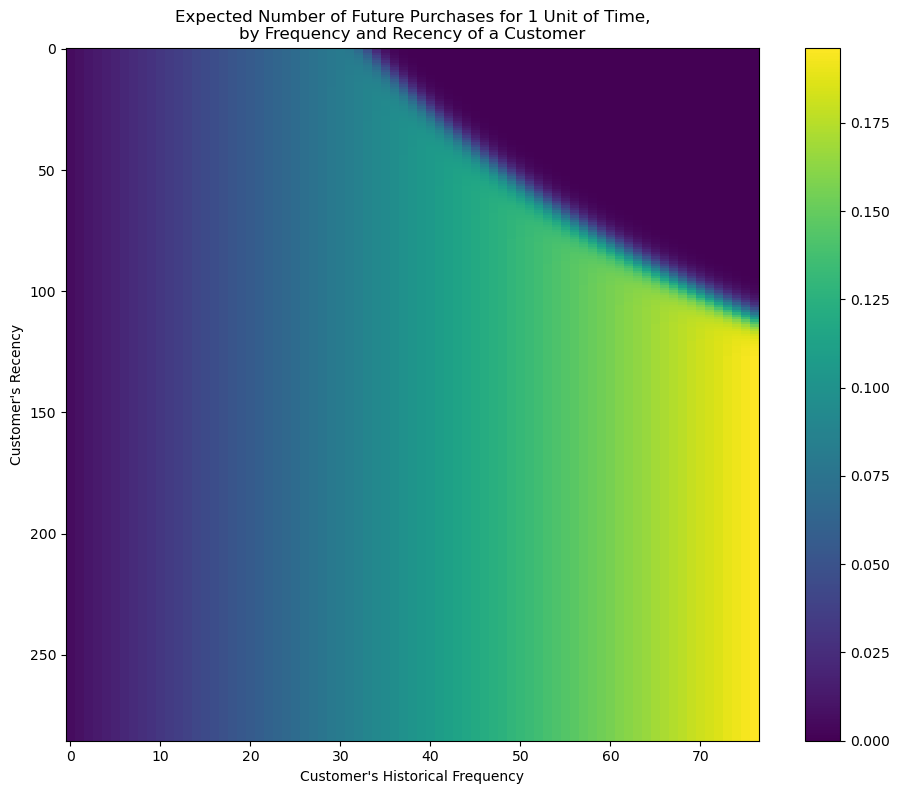

In [49]:
plt.figure(figsize=(12,9))
plot_frequency_recency_matrix(bgf)
plt.show()

# Expected Number of Purchases in 6 Months

In [50]:
t = 180 # 30 day period
clv['expected_purc_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
clv.sort_values(by='expected_purc_6_months',ascending=False).head(5)

,frequency,recency,T,monetary_value,expected_purc_6_months
Customer ID,,,,,
17841.0,76.0,284.0,285.0,288.458158,35.331535
12748.0,74.0,284.0,285.0,195.779865,34.433079
14606.0,67.0,284.0,285.0,129.153881,31.288481
15311.0,63.0,279.0,285.0,435.923968,29.491569
12971.0,51.0,280.0,284.0,135.930196,24.161130


In [51]:
#Expected Number of Purchases ın 12 Months

t = 360
clv['expected_purc_12_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
clv.sort_values(by='expected_purc_12_months',ascending=False).head(5)

,frequency,recency,T,monetary_value,expected_purc_6_months,expected_purc_12_months
Customer ID,,,,,,
17841.0,76.0,284.0,285.0,288.458158,35.331535,70.663070
12748.0,74.0,284.0,285.0,195.779865,34.433079,68.866157
14606.0,67.0,284.0,285.0,129.153881,31.288481,62.576963
15311.0,63.0,279.0,285.0,435.923968,29.491569,58.983137
12971.0,51.0,280.0,284.0,135.930196,24.161130,48.322260


# Gamma - Gamma Model
The Gamma-Gamma Model can predict the most likely value per transaction in the future

Assumption:-     
    
The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [53]:
clv[['frequency','monetary_value']].corr() 

,frequency,monetary_value
frequency,1.000000,0.056882
monetary_value,0.056882,1.000000


In [54]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv["frequency"],
        clv["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 1160 subjects, p: 3.81, q: 0.35, v: 3.74>

# 6 months Customer Lifetime Value

In [55]:
clv['6_Months_CLV']=ggf.customer_lifetime_value(bgf,
                                   clv["frequency"],
                                   clv["recency"],
                                   clv["T"],
                                   clv["monetary_value"],
                                   time=6,
                                   freq='D',
                                   discount_rate=0.01)


In [56]:
clv.sort_values('6_Months_CLV',ascending=False).head()

,frequency,recency,T,monetary_value,expected_purc_6_months,expected_purc_12_months,6_Months_CLV
Customer ID,,,,,,,
13089.0,47.0,270.0,281.0,725.002128,22.528820,45.057639,15835.785200
17511.0,19.0,280.0,285.0,1640.084211,9.725529,19.451058,15548.164348
14298.0,18.0,261.0,272.0,1630.847222,9.587356,19.174711,15248.716803
18102.0,15.0,269.0,279.0,1645.922000,8.049147,16.098293,12945.566133
15311.0,63.0,279.0,285.0,435.923968,29.491569,58.983137,12453.204729


# Segmentation Customers by 6 Months CLV

In [57]:
clv['Segment'] =  pd.qcut(clv['6_Months_CLV'],4,labels = ['Hibernating','Need Attention',
                                                          'Loyal Customers','Champions'])

In [58]:
clv.head()

,frequency,recency,T,monetary_value,expected_purc_6_months,expected_purc_12_months,6_Months_CLV,Segment
Customer ID,,,,,,,,
12747.0,7.0,260.0,281.0,341.974286,4.378501,8.757002,1484.671908,Loyal Customers
12748.0,74.0,284.0,285.0,195.779865,34.433079,68.866157,6528.215482,Champions
12823.0,3.0,169.0,208.0,260.100000,3.141599,6.283198,840.785554,Need Attention
12826.0,3.0,187.0,277.0,225.286667,2.589581,5.179162,600.730317,Hibernating
12828.0,2.0,31.0,42.0,94.255000,5.307312,10.614625,538.645675,Hibernating


# Final Dataframe

In [59]:
clv.groupby('Segment').mean()

,frequency,recency,T,monetary_value,expected_purc_6_months,expected_purc_12_months,6_Months_CLV
Segment,,,,,,,
Hibernating,2.996552,170.941379,232.872414,141.698778,2.966129,5.932257,416.088054
Need Attention,3.627586,178.237931,228.593103,259.498822,3.314088,6.628177,831.267237
Loyal Customers,4.900000,191.596552,226.241379,349.572569,3.976794,7.953588,1299.135671
Champions,9.772414,207.920690,232.558621,582.668141,6.230067,12.460133,3117.365062


# Group by Segment

In [60]:
clv.groupby('Segment').mean()


,frequency,recency,T,monetary_value,expected_purc_6_months,expected_purc_12_months,6_Months_CLV
Segment,,,,,,,
Hibernating,2.996552,170.941379,232.872414,141.698778,2.966129,5.932257,416.088054
Need Attention,3.627586,178.237931,228.593103,259.498822,3.314088,6.628177,831.267237
Loyal Customers,4.900000,191.596552,226.241379,349.572569,3.976794,7.953588,1299.135671
Champions,9.772414,207.920690,232.558621,582.668141,6.230067,12.460133,3117.365062


# Thank you